train a model to predict what the single dice classes are

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1


# Set parameters
img_width, img_height = 30, 30
batch_size = 32

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Assuming 3 classes
])

# model = Sequential([
#     Conv2D(16, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
#     MaxPooling2D((2, 2)),
#     Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l1(0.01)),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(6, activation='softmax')  # Assuming 3 classes
# ])





model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, 
    horizontal_flip=True,  # Enable horizontal flip
    rotation_range=180,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #zoom_range=0.05,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

train_generator = train_datagen.flow_from_directory(
    '/home/bule/projects/Dice/workspace/data/new_filz/Dicesides',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale images
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/home/bule/projects/Dice/workspace/data/new_filz/Dicesides',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',  # Specify grayscale images
    subset='validation'
)

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=1000  # Adjust the number of epochs according to your needs
)


Found 163 images belonging to 6 classes.
Found 36 images belonging to 6 classes.
Epoch 1/1000


5/5 [==============================] - 0s 26ms/step - loss: 1.8128 - accuracy: 0.1562 - val_loss: 1.7697 - val_accuracy: 0.2188
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.7812 - accuracy: 0.1603 - val_loss: 1.7669 - val_accuracy: 0.2188
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.7965 - accuracy: 0.1756 - val_loss: 1.7667 - val_accuracy: 0.1562
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.7644 - accuracy: 0.2443 - val_loss: 1.7752 - val_accuracy: 0.2812
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.7793 - accuracy: 0.1832 - val_loss: 1.7469 - val_accuracy: 0.2500
Epoch 6/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.7622 - accuracy: 0.2366 - val_loss: 1.7741 - val_accuracy: 0.1562
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.7694 - accuracy: 0.2214 - val_loss: 1.7507 - val_accuracy: 0.1875
Epoch 8/1000
5/5 [========

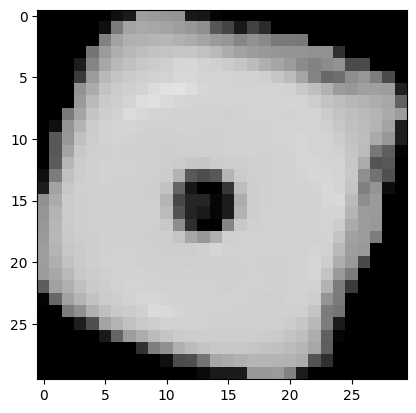

1/1 [==============================] - 0s 8ms/step
[[9.9958140e-01 2.7688311e-05 3.9097472e-04 4.8002461e-12 6.2728878e-10
  1.9545752e-11]]


In [23]:
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt





def make_prediction(model, file_path):
    # Load the image file, converting it to a numpy array
    img = image.load_img(file_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)

    # Rescale the image (as we did for the training images)
    img_array /= 255.0

    # Add a new axis to make the image array compatible with the model (expects a batch)
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    return prediction

# Usage
# model should be the trained model you want to use for prediction
# '/path/to/image.png' should be the path to the image you want to predict

img_path = "/home/bule/projects/Dice/data/single_dices/single_dices/dice_classes/1/dice25.png"
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

prediction = make_prediction(model, img_path)
print(prediction)


In [24]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model_single_dices.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved.")


INFO:tensorflow:Assets written to: /tmp/tmpq0qtty1e/assets


INFO:tensorflow:Assets written to: /tmp/tmpq0qtty1e/assets


Model converted to TensorFlow Lite and saved.


2023-11-04 19:38:39.640056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-04 19:38:39.640069: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-04 19:38:39.640218: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpq0qtty1e
2023-11-04 19:38:39.640958: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-04 19:38:39.640963: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpq0qtty1e
2023-11-04 19:38:39.642671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-04 19:38:39.643204: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-11-04 19:38:39.670406: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpq0qtty1e
2023-11

## Create Augmented testset

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential

# Assuming you have a root directory where each subdirectory represents a class
root_dir = "/home/bule/projects/Dice/workspace/data/single_dices/testset" 
save_dir = "/home/bule/projects/Dice/workspace/data/single_dices/augmented_testset"


# Ensure the save directory exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define image data generator with rotations
datagen = ImageDataGenerator(rotation_range=360,  fill_mode='constant',cval=0)

# Function to add noise to an image
import numpy as np

def add_noise(img):
    img = img.astype('float32')

    original_shape = img.shape  # Store the original shape
    flattened_img = img.flatten()
    noise = np.random.normal(loc=10.0, scale=1, size=flattened_img.shape)
    noisy_flattened_img = flattened_img + noise

    noisy_img = noisy_flattened_img.reshape(original_shape)

    noisy_img = np.clip(noisy_img, 0, 255)
    
    return noisy_img


# Function to process and save images from a directory
def process_and_save_images_from_directory(class_dir,save_dir):
    for filename in os.listdir(class_dir):
        if filename.endswith(".png"):
            # Load image
            img_path = os.path.join(class_dir, filename)
            save_path = os.path.join(save_dir, filename)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            # # Apply rotation augmentation and add noise
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=save_dir, save_prefix='aug', save_format='png'):
                # Add noise
                noisy_image = add_noise(batch[0])
                noisy_image = array_to_img(noisy_image)

                # Save the noisy image
                noisy_image.save(os.path.join(save_dir, f'noisy_{i}_{filename}'))
                
                i += 1
                if i >= 2:  # Decide how many augmented images you want per original image
                    break


# Change this to the path of your dataset
for class_name in os.listdir(root_dir):
    print(class_name)
    class_dir = os.path.join(root_dir, class_name)
    target_class_dir = os.path.join(save_dir, class_name)
    if os.path.isdir(class_dir):
        process_and_save_images_from_directory(class_dir,target_class_dir)


2024-02-29 11:14:15.373251: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-29 11:14:15.374494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-29 11:14:15.391870: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 11:14:15.391888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 11:14:15.391900: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

1
5
6
3
4
2
